In [1]:
import collections
import heapq
import logging

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

logging.basicConfig(
    # filename="log.log",
    # filemode="a",
    format="%(asctime)s %(levelname)-8s [%(name)s] : %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

logger = logging.getLogger(__name__)

In [2]:
# Defining different types of records used throughout the simulation.
EndOfTimeStepRecord = collections.namedtuple(
    "EndOfTimeStepRecord", ("date", "ending_stock")
)
OrderPlacementRecord = collections.namedtuple(
    "OrderPlacementRecord", ("arrival_date", "units_ordered", "order_placement_date")
)
SalesRecord = collections.namedtuple("SalesRecord", ("date", "units_sold"))
LossRecord = collections.namedtuple("LossRecord", ("date", "units_lost"))

# A generic object used for some visualizations
HorizontalLineInfo = collections.namedtuple("HorizontalLineInfo", ("label", "value"))

In [4]:
# Generate / create an input signal
def generate_normal_input(mean=10, std=3, size=100, floor_value=0, round_input=True):
    normal_input = np.random.normal(loc=mean, scale=std, size=size)
    
    # Truncate all entries using the given floor_value (e.g., floor_value=0 means negative values are not allowed).
    if floor_value is not None:
        normal_input[normal_input <= floor_value] = floor_value
    
    # A boolean flag used to round values.  The default rounding strategy will round inputs with decimal values of 0.5 and below down to the nearest integer; inputs with higher decimal values will be rounded up to the next highest integer value.
    if round_input:
        normal_input = np.round(normal_input)
    return normal_input


def generate_historical_data(*args, **kwargs):
    historical_data = generate_normal_input(*args, **kwargs)
    return historical_data

def generate_forecasted_data(*args, **kwargs):
    forecasted_data = generate_normal_input(*args, **kwargs)
    return forecasted_data

These cells contain supplementary functions used to help evaluate and visualize a simulation run.

In [5]:
# This function is used to assess the performance of a simulation.
def calculate_profit(simulation_data, product_info):
    unit_cost = product_info["unit_cost"]
    selling_price = product_info["selling_price"]
    holding_cost = product_info["holding_cost"]
    order_cost = product_info["order_cost"]

    revenue = sum(r.units_sold for r in simulation_data["units_sold"]) * selling_price
    order_costs = len(simulation_data["orders_placed"]) * order_cost
    holding_costs = (
        sum(r.ending_stock for r in simulation_data["time_step_stock_counts"])
        * holding_cost
    )
    unit_costs = (
        sum(r.units_ordered for r in simulation_data["orders_placed"]) * unit_cost
    )

    profit = revenue - order_costs - holding_costs - unit_costs

    return profit

def calculate_losses(simulation_data, product_info):
    unit_cost = product_info["unit_cost"]
    selling_price = product_info["selling_price"]

    units_lost = sum(r.units_lost for r in simulation_data["units_lost"])

    loss = units_lost * (selling_price - unit_cost)
    return loss


def plot_inventory_graph(simulation_data, horizontal_line_info=None):
    G = simulation_data["time_step_stock_counts"]
    plt.plot(list(p.ending_stock for p in G), label="Inventory")

    if horizontal_line_info is not None:
        plt.plot([horizontal_line_info.value] * len(G), label=horizontal_line_info.label)
    plt.legend(loc="upper left")
    plt.title("Inventory Levels")
    plt.xlabel("Time Step")
    plt.ylabel("Inventory")
    plt.show()

In [6]:
# Implement a restocking strategy
def threshold_restock_strategy(
    current_stock,
    reorder_threshold,
    order_fill_amount_function,
    lead_time,
    current_time_step,
    order_fill_params=None,
):
    """
    When `current_stock` falls below the `reorder_threshold` create an order for `order_fill_amount` units.
    """
    order_placed = None

    if order_fill_params is None:
        order_fill_amount = order_fill_amount_function()
    else:
        order_fill_amount = order_fill_amount_function(current_stock, **order_fill_params)
    if (current_stock <= reorder_threshold) and (order_fill_amount > 0):

        order_placed = OrderPlacementRecord(
            arrival_date=current_time_step + lead_time,
            units_ordered=order_fill_amount,
            order_placement_date=current_time_step,
        )

    return order_placed


In [7]:
# Simulate activity using the restocking strategy

def simulate(
    starting_stock,
    sales_data,
    inventory_check_frequency,
    strategy_params,
):
    """
    Simulate the activity based on the given parameters.
    """
    simulation_data = {
        "time_step_stock_counts": [],
        "orders_placed": [],
        "units_sold": [],
        "units_lost": [],
    }
    current_stock = starting_stock
    open_orders_heap = []

    for time_step, sales in enumerate(sales_data):

        # Check if any orders have been delievered and add them to the stock
        # NOTE: This current model makes the assumption that orders arrive at the start of the time period.
        if len(open_orders_heap) > 0:
            # Check that there are not errenous orders lingering
            while (
                len(open_orders_heap) > 0
                and open_orders_heap[0].arrival_date < time_step
            ):
                logger.error(
                    f"A stale order was found in the system of {open_orders_heap[0]}.  Please look into what process placed this order."
                )
                heapq.heappop(open_orders_heap)

            # Check if there are any orders which are arriving at the current time step.
            while (
                len(open_orders_heap) > 0
                and open_orders_heap[0].arrival_date == time_step
            ):
                received_order = heapq.heappop(open_orders_heap)
                logger.debug(f"Received the following order: {received_order}.")
                current_stock += received_order.units_ordered

        # Perform the activity of sales for the given time period

        # Record information about sales activity that occured
        # This could include potential for losses.
        if current_stock >= sales:
            current_stock -= sales
            sales_record = SalesRecord(date=time_step, units_sold=sales)
            simulation_data["units_sold"].append(sales_record)

        else:

            sales_record = SalesRecord(date=time_step, units_sold=current_stock)
            simulation_data["units_sold"].append(sales_record)

            loss_record = LossRecord(
                date=time_step, units_lost=abs(sales - current_stock)
            )
            simulation_data["units_lost"].append(loss_record)
            logger.debug(
                f"Failed to complete {loss_record.units_lost} sales on time_step {loss_record.date}."
            )

            current_stock = 0

        # Add the end of time step status to the records.
        end_of_time_step_record = EndOfTimeStepRecord(
            date=time_step, ending_stock=current_stock
        )
        simulation_data["time_step_stock_counts"].append(end_of_time_step_record)

        # Perform a check at the end of the day to see if an order should be placed.

        if time_step % inventory_check_frequency == 0:
            # NOTE: For now we will limit to only allowing 1 order to be placed at a time.
            if len(open_orders_heap) > 0:
                continue
            restock_order = threshold_restock_strategy(
                current_stock,
                current_time_step=time_step,
                **strategy_params,
            )
            if restock_order is not None:
                logger.debug(f"The following order has been placed {restock_order}.")
                simulation_data["orders_placed"].append(restock_order)
                heapq.heappush(open_orders_heap, restock_order)

    return simulation_data


### Case 1: Continuous Review (Q-System)

In the configuration below the simulation performs continuous monitoring by checking the status at the end of each time step and placing an order when appropriate (as per the given parameters).

The main USER inputs for this strategy are:
- STARTING_STOCK : The amount of stock at the initial time step
- REORDER_THRESHOLD : The point at which the system places an order for more stock
- ORDER_FILL_AMOUNT : The size of the order that should be placed by the system

Other info needed for simulation:
- LEAD_TIME : The number of time steps between when an order is placed and when it arrives.

Other info needed for analysis of simulation:
- PRODUCT_INFO : this includes factors such as cost, selling price, holding_cost, order_cost, etc.

2022-01-05 11:25:51 INFO     [__main__] : This run of the simulation generated a profit of 6122.24.
2022-01-05 11:25:51 INFO     [__main__] : This run of the simulation suffered a loss of 1085.0 due to lack of inventory.


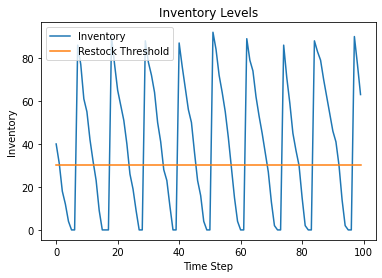

In [8]:
# NOTE: Some of these settings are specfic to the case of using continuous inventory management.
INVENTORY_CHECK_FREQUENCY = 1 # A value of 1 indicates that the stock is checked at the end of each day.

# Main User Inputs
STARTING_STOCK = 50
REORDER_THRESHOLD = 30 # Use a value of float("inf") in order to simulate the behavior of periodic checks
ORDER_FILL_AMOUNT = 100 # This strategy uses a constant value when placing an order.
LEAD_TIME = 5

FAKE_PRODUCT_INFO = {
    "unit_cost": 3,
    "selling_price": 10,
    "holding_cost": 0.01,
    "order_cost": 1,
}


strategy_params = {
    "lead_time": LEAD_TIME,
    "reorder_threshold": REORDER_THRESHOLD,
    "order_fill_amount_function": lambda : ORDER_FILL_AMOUNT,
}

historical_data = generate_historical_data() # NOTE: This is currently a placeholder that will be needed in a real environment; it is not used for the purposes of this simulation.
forecasted_data = generate_forecasted_data()


simulation_data = simulate(
    STARTING_STOCK,
    forecasted_data,
    inventory_check_frequency=INVENTORY_CHECK_FREQUENCY,
    strategy_params=strategy_params,
)

simulation_profit = calculate_profit(simulation_data, FAKE_PRODUCT_INFO)
logger.info(f"This run of the simulation generated a profit of {simulation_profit}.")

simulation_loss = calculate_losses(simulation_data, FAKE_PRODUCT_INFO)
logger.info(f"This run of the simulation suffered a loss of {simulation_loss} due to lack of inventory.")

restock_line = HorizontalLineInfo(label="Restock Threshold", value=REORDER_THRESHOLD)
plot_inventory_graph(simulation_data, restock_line)

### Case 2: Periodic Review (P-System)

In the configuration below the simulation performs periodic monitoring by checking the status at the end of each review period and placing an order when appropriate (as per the given parameters) with the goal of having the order bring the stock up to the target restock level when it arrives.

The main USER inputs for this strategy are:
- STARTING_STOCK : The amount of stock at the initial time step.
- INVENTORY_CHECK_FREQUENCY : The number of time steps at which reviews should be conducted (NOTE: Under the current implementation this should be at least as long as the LEAD_TIME for the given product; otherwise you may see errors in the simulation).
- TARGET_RESTOCK_LEVEL : The amount of stock you hope to be at when a placed order arrives (NOTE: The strategy takes into account lead time and places the order accounting for the expected number of sales that might happen during the lead time).

Other info needed for simulation:
- LEAD_TIME : The number of time steps between when an order is placed and when it arrives.

Other info needed for analysis of simulation:
- PRODUCT_INFO : this includes factors such as cost, selling price, holding_cost, order_cost, etc.

2022-01-04 12:06:41 INFO     [__main__] : This run of the simulation generated a profit of 6456.5599999999995.
2022-01-04 12:06:41 INFO     [__main__] : This run of the simulation suffered a loss of 0 due to lack of inventory.


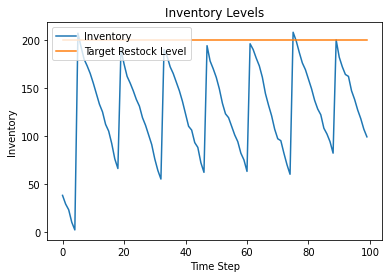

In [18]:
# NOTE: Some of these settings are specfic to the case of using periodic inventory management.
REORDER_THRESHOLD = float("inf") # This is set to infinity since the value of this strategy is placed on the reordering function

# Main User Inputs
STARTING_STOCK = 50
INVENTORY_CHECK_FREQUENCY = 14
TARGET_RESTOCK_LEVEL = 200
LEAD_TIME = 5

FAKE_PRODUCT_INFO = {
    "unit_cost": 3,
    "selling_price": 10,
    "holding_cost": 0.01,
    "order_cost": 1,
}


historical_data = generate_historical_data() # NOTE: This step is not currently used in this demo.
forecasted_data = generate_forecasted_data()

# NOTE: This is an example of a value that is derived from historical data, but this could also be adjusted by the user if desired.
EXPECTED_LEAD_TIME_DEMAND = np.round(historical_data.mean() * LEAD_TIME)

def periodic_order_function(current_stock, target_restock_level, expected_lead_time_demand):
    return target_restock_level + expected_lead_time_demand - current_stock #TODO: There is a subtle flaw in this logic that should be fixed (regarding the idea of accounting for sales that can't actually happen).

strategy_params = {
    "lead_time": LEAD_TIME,
    "reorder_threshold": REORDER_THRESHOLD,
    "order_fill_amount_function": periodic_order_function,
    "order_fill_params": {
        "target_restock_level" : TARGET_RESTOCK_LEVEL,
        "expected_lead_time_demand": EXPECTED_LEAD_TIME_DEMAND,
    }
    
}


simulation_data = simulate(
    STARTING_STOCK,
    forecasted_data,
    inventory_check_frequency=INVENTORY_CHECK_FREQUENCY,
    strategy_params=strategy_params,
)

simulation_profit = calculate_profit(simulation_data, FAKE_PRODUCT_INFO)
logger.info(f"This run of the simulation generated a profit of {simulation_profit}.")

simulation_loss = calculate_losses(simulation_data, FAKE_PRODUCT_INFO)
logger.info(f"This run of the simulation suffered a loss of {simulation_loss} due to lack of inventory.")

restock_line = HorizontalLineInfo(label="Target Restock Level", value=TARGET_RESTOCK_LEVEL)
plot_inventory_graph(simulation_data, restock_line)